In [1]:
import os, glob
from moviepy.editor import VideoFileClip
%config InlineBackend.figure_format = 'retina'

In [2]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

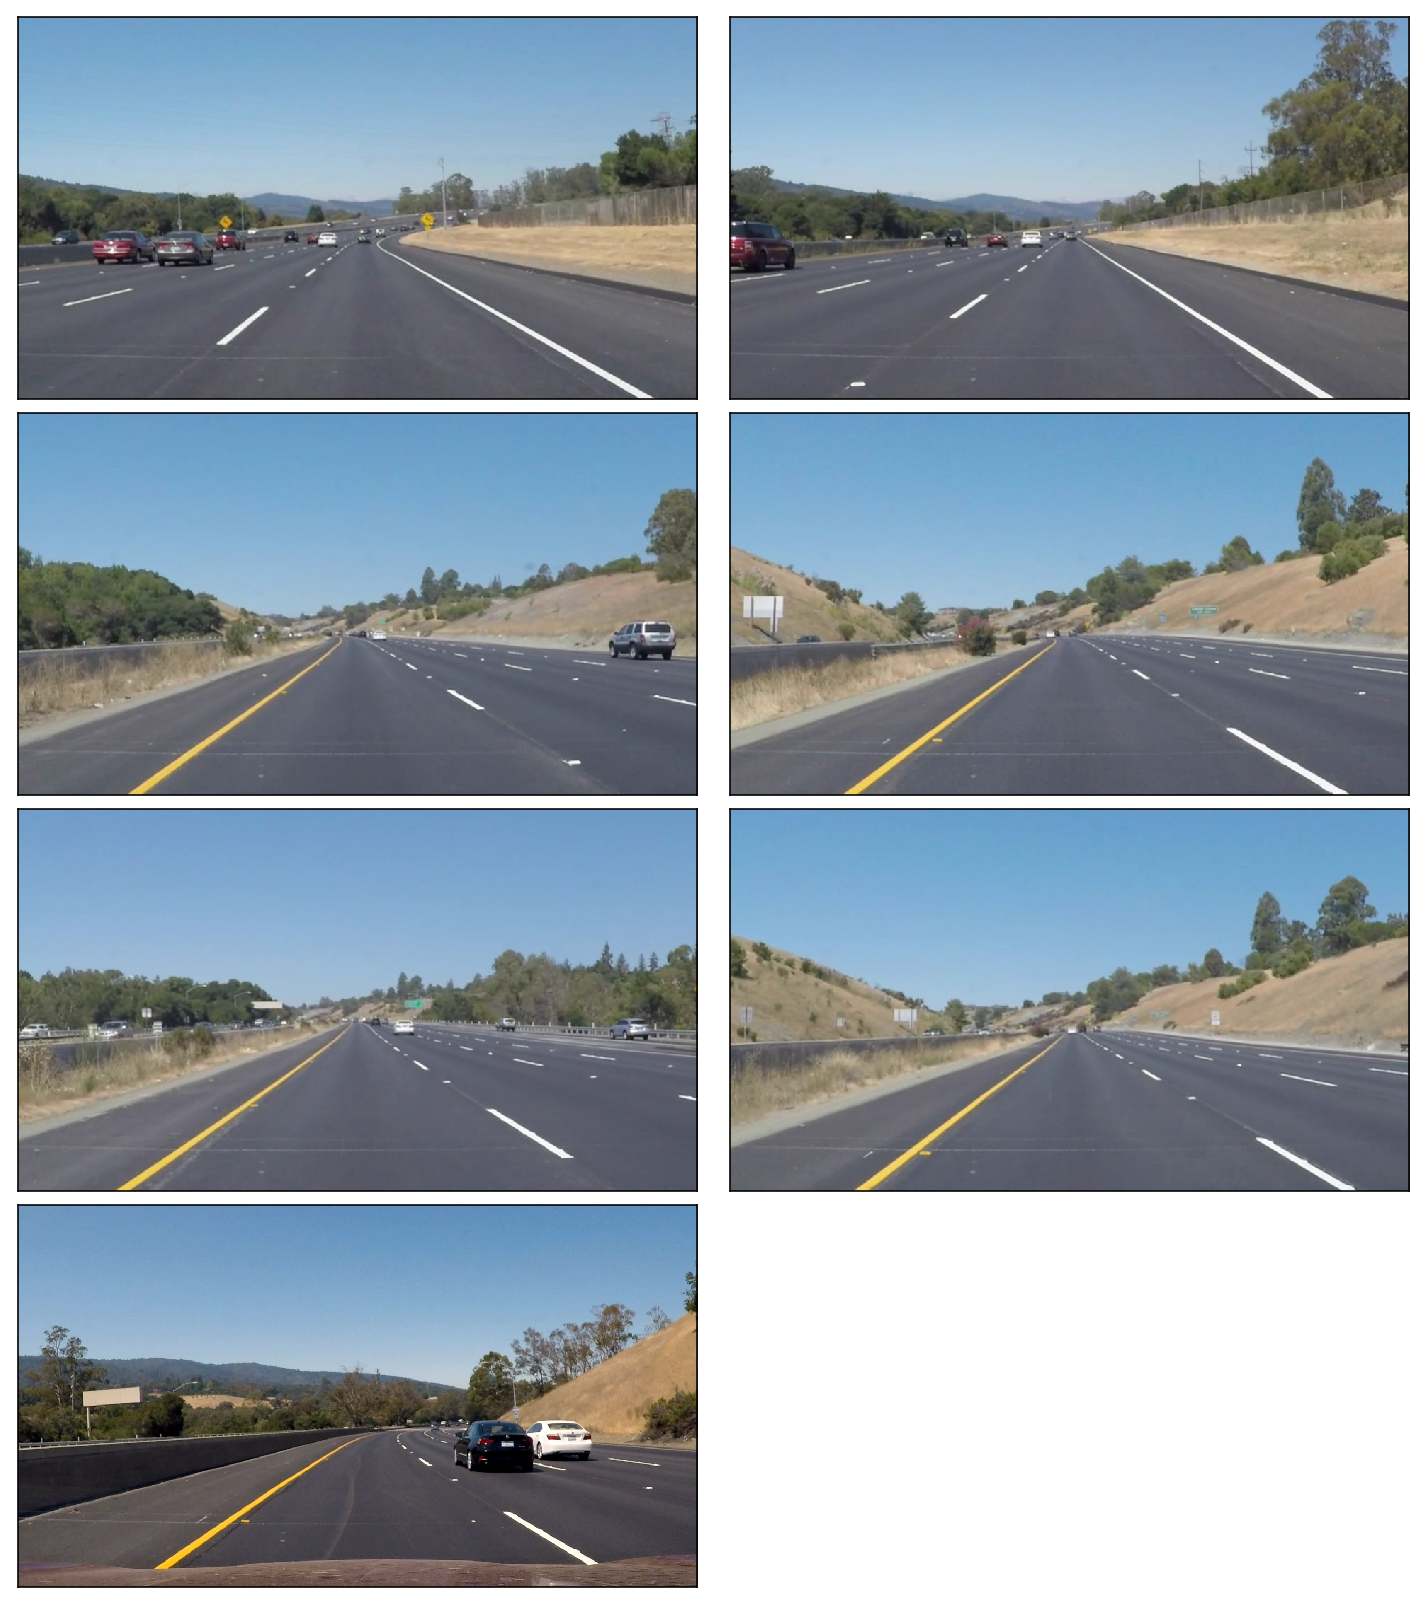

In [3]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

show_images(test_images)

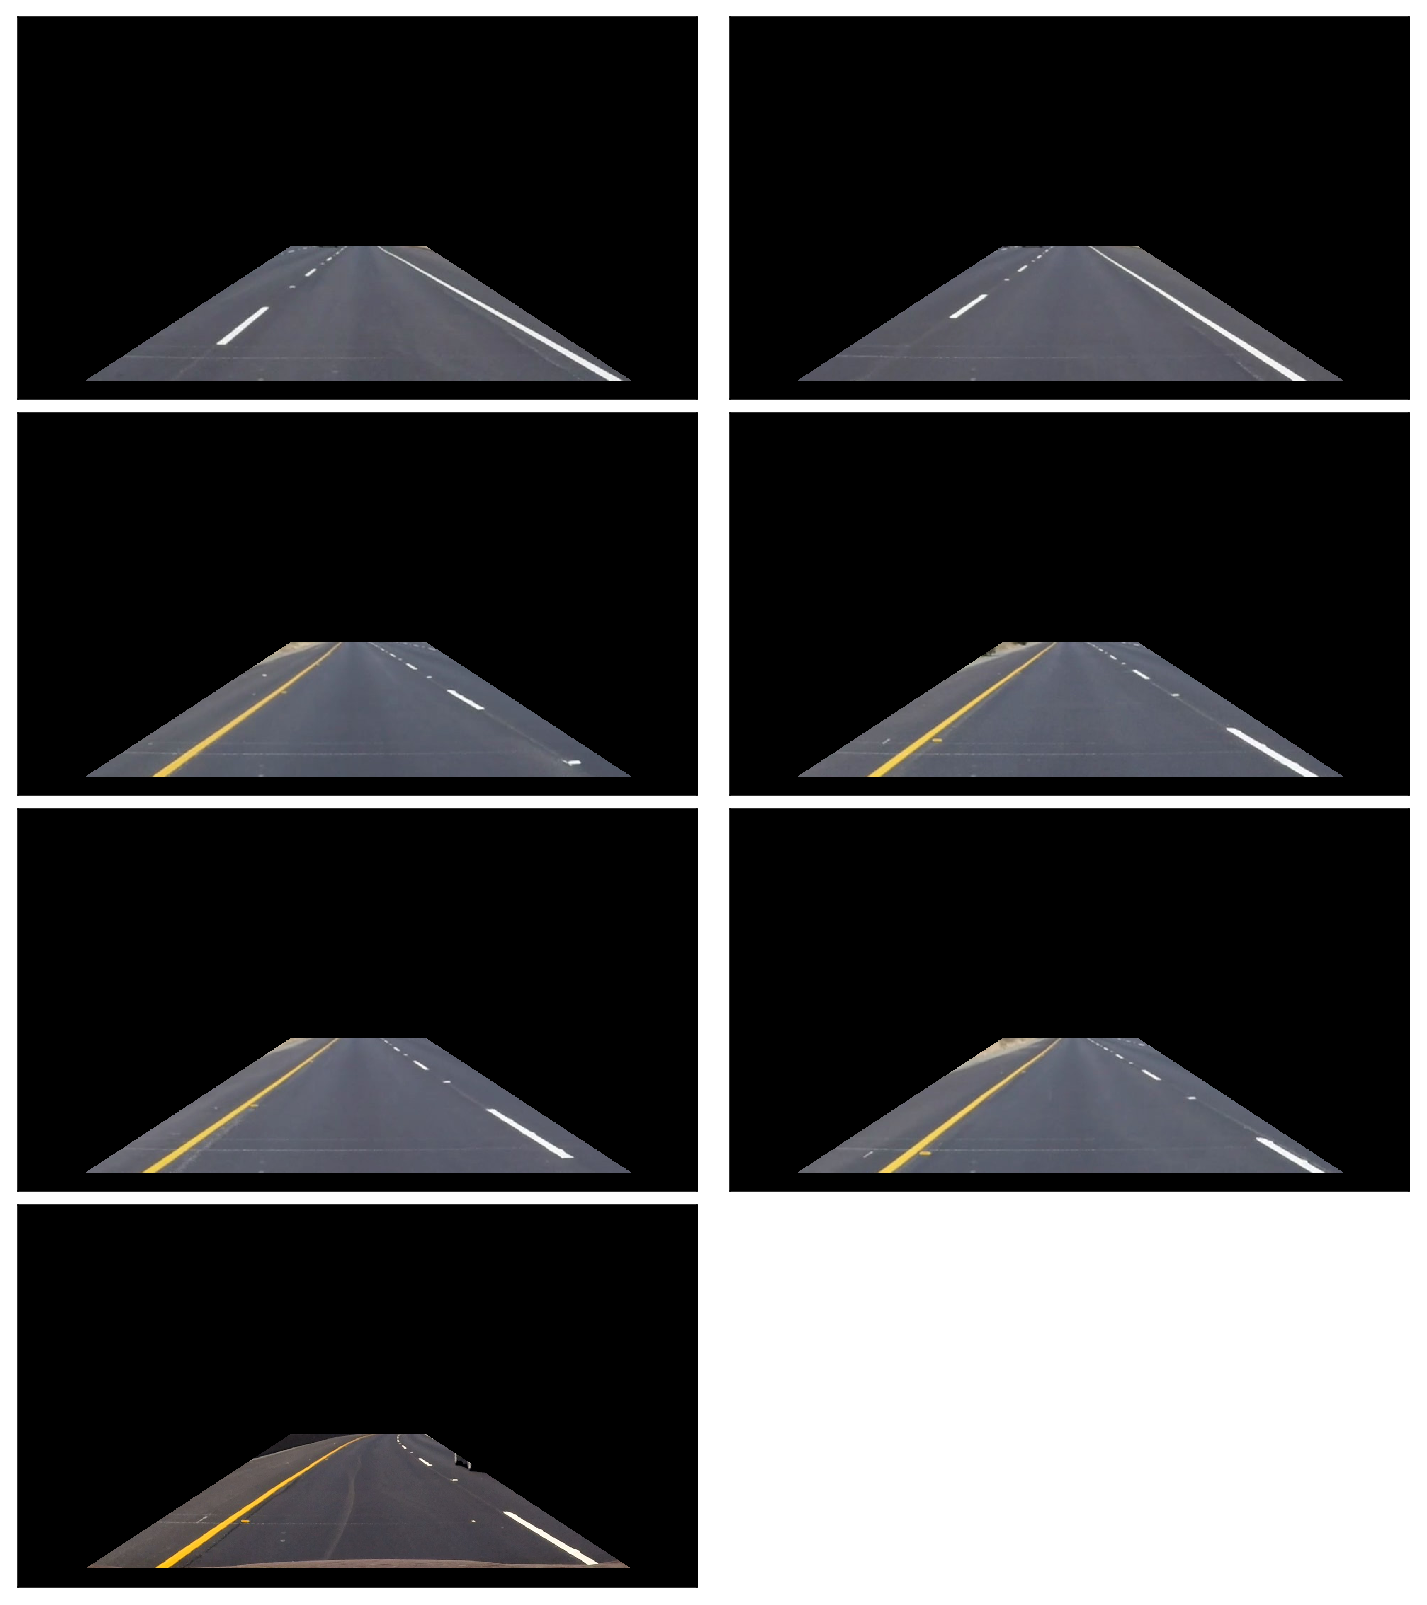

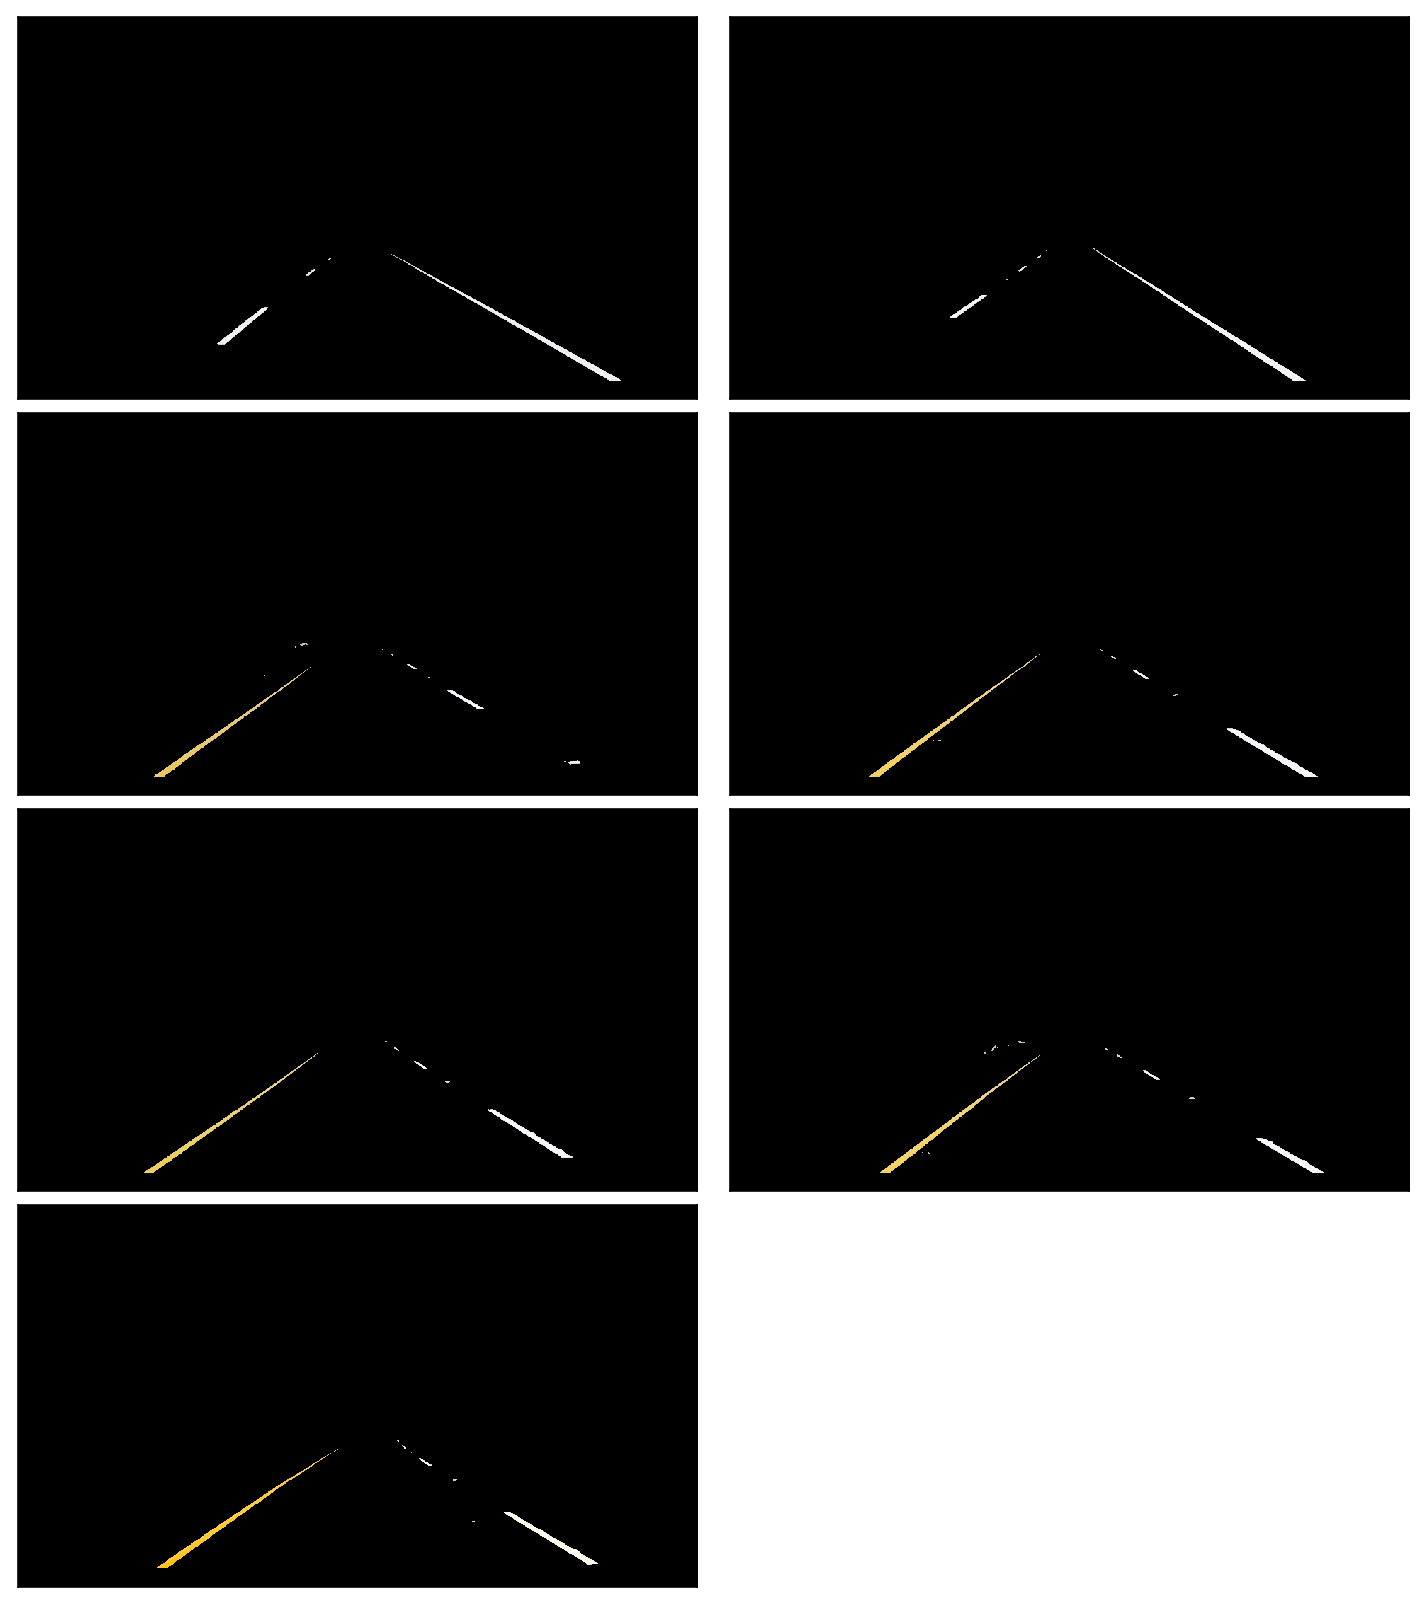

In [5]:
# Define our color selection criteria
def select_rgb_color(image):
    color_select = np.copy(image)

    red_threshold = 190
    green_threshold = 190
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Identify pixels below the threshold
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
                | (image[:,:,1] < rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    
    # Return the image                 
    return color_select

white_yellow_images = list(map(select_rgb_color, roi_images))
show_images(white_yellow_images)

# image is expected be in RGB color space
#def select_rgb_white_yellow(image): 
    # white color mask
#    lower = np.uint8([200, 200, 200])
#    upper = np.uint8([255, 255, 255])
#    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
#    lower = np.uint8([190, 190,   0])
#    upper = np.uint8([255, 255, 255])
#    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
#    mask = cv2.bitwise_or(white_mask, yellow_mask)
#    masked = cv2.bitwise_and(image, image, mask = mask)
#    return masked

#show_images(list(map(select_rgb_white_yellow, test_images)))

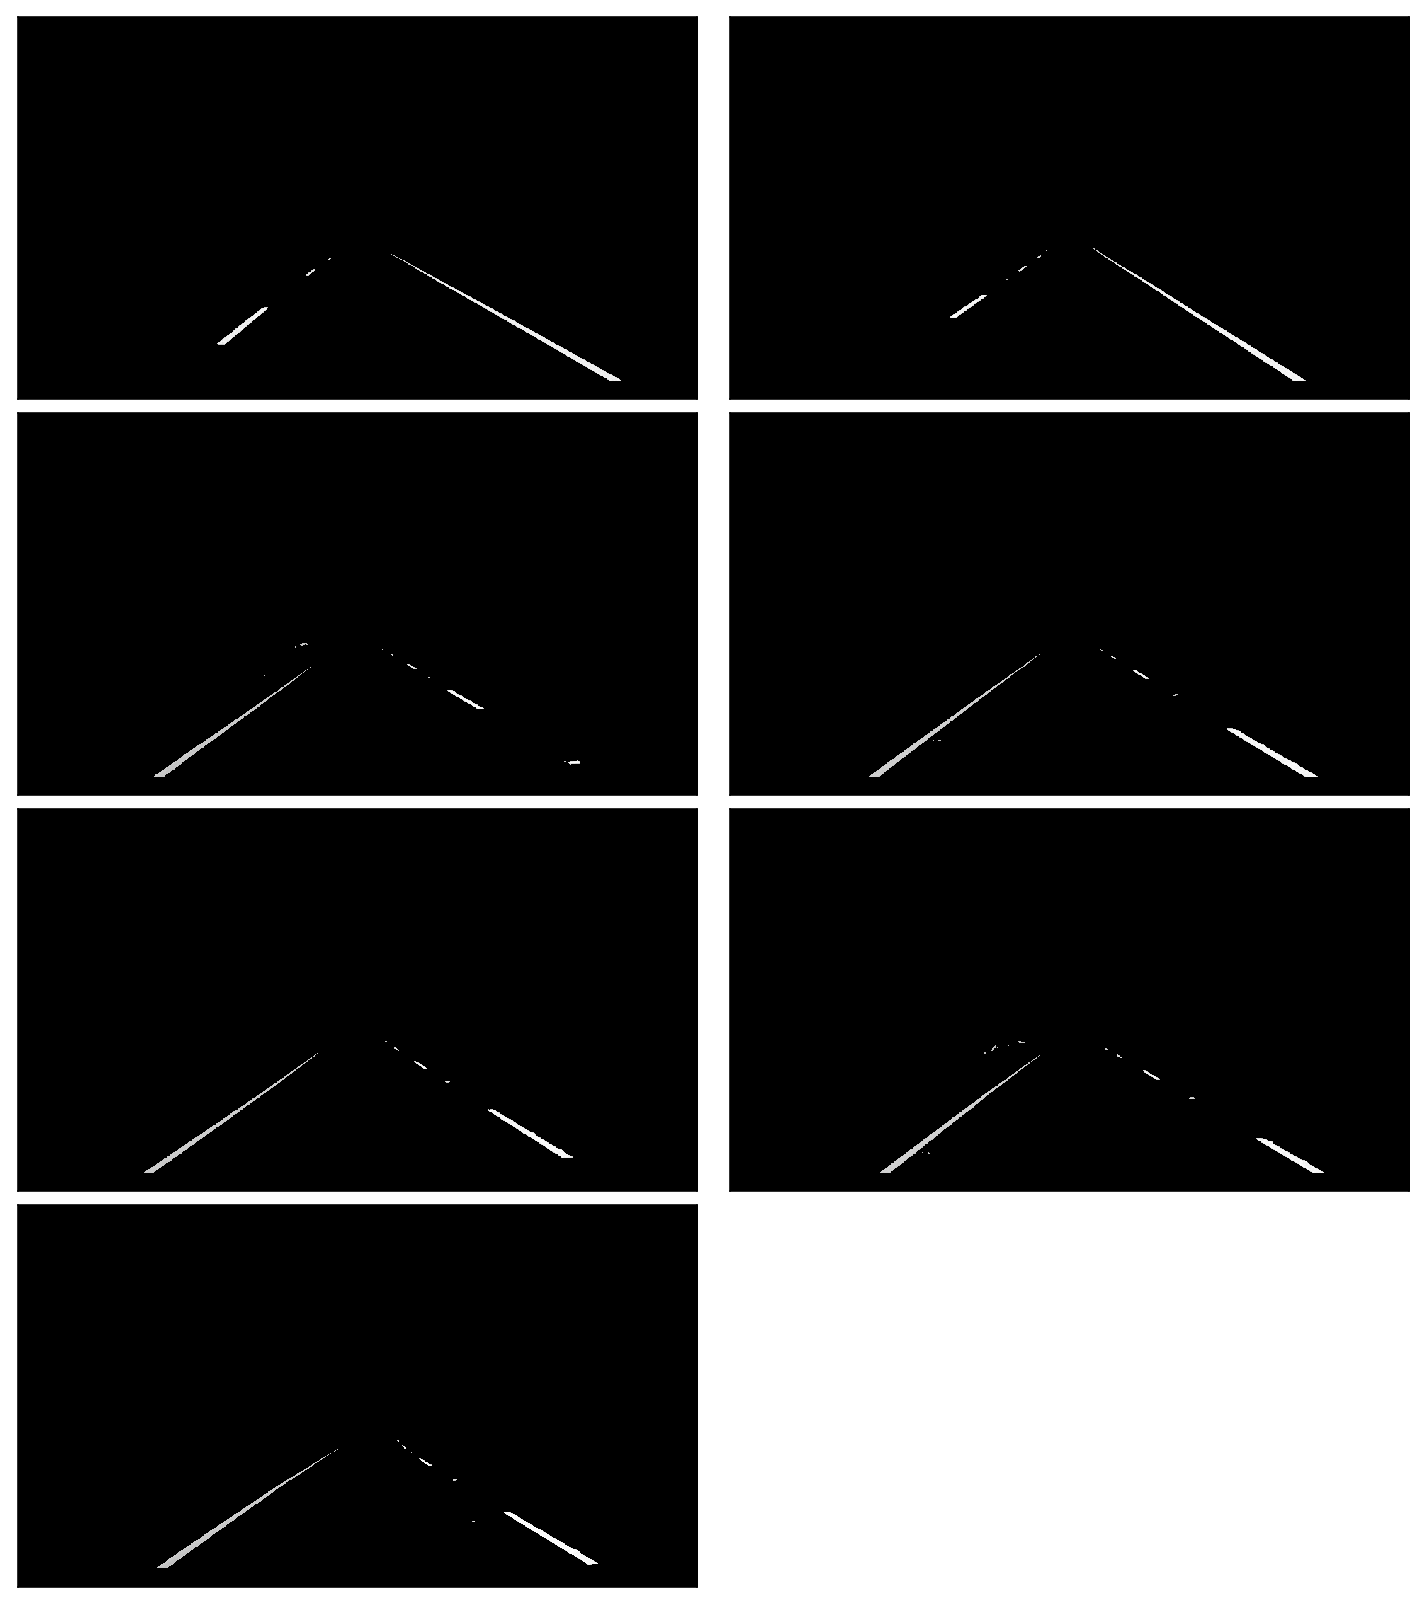

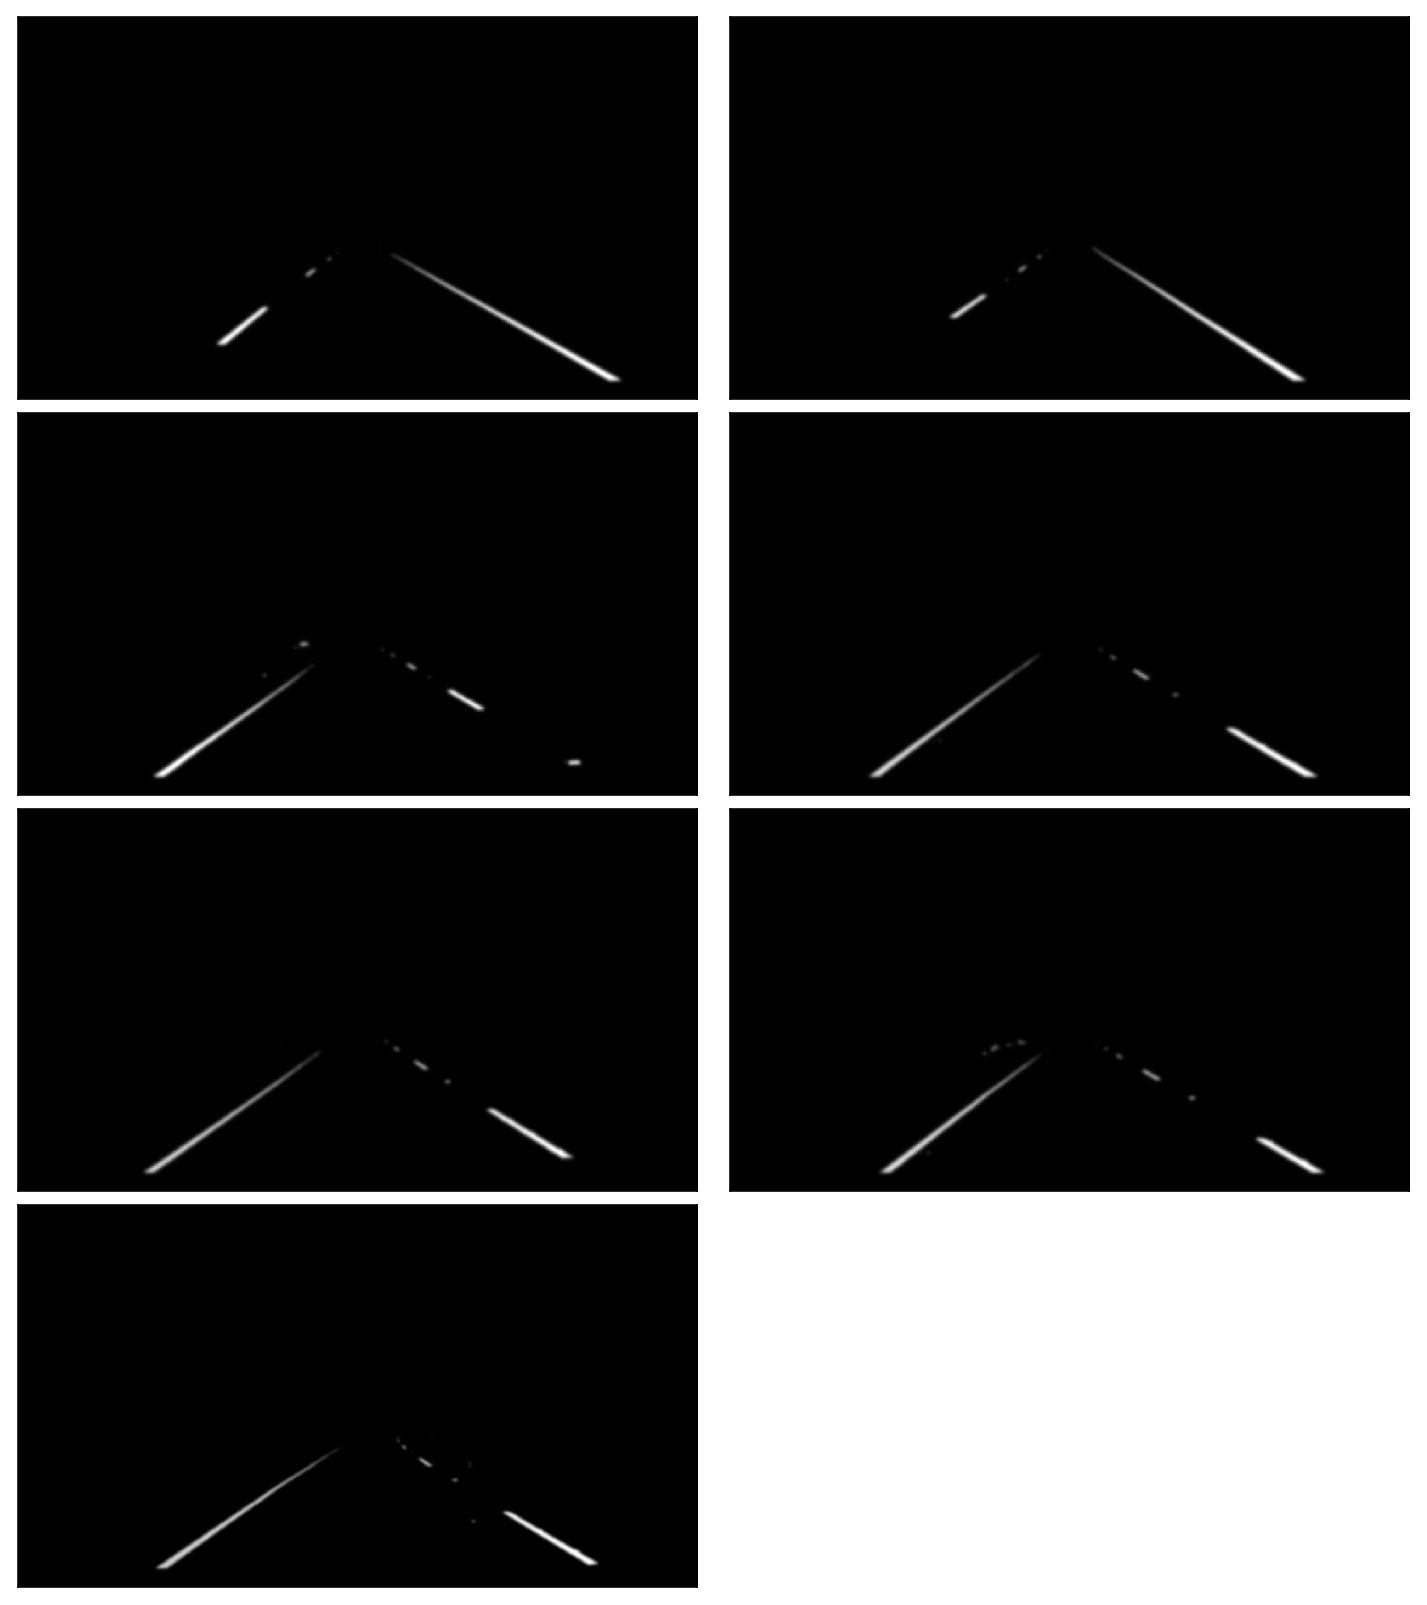

In [7]:
def apply_smoothing(image, kernel_size=15):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))
show_images(blurred_images)

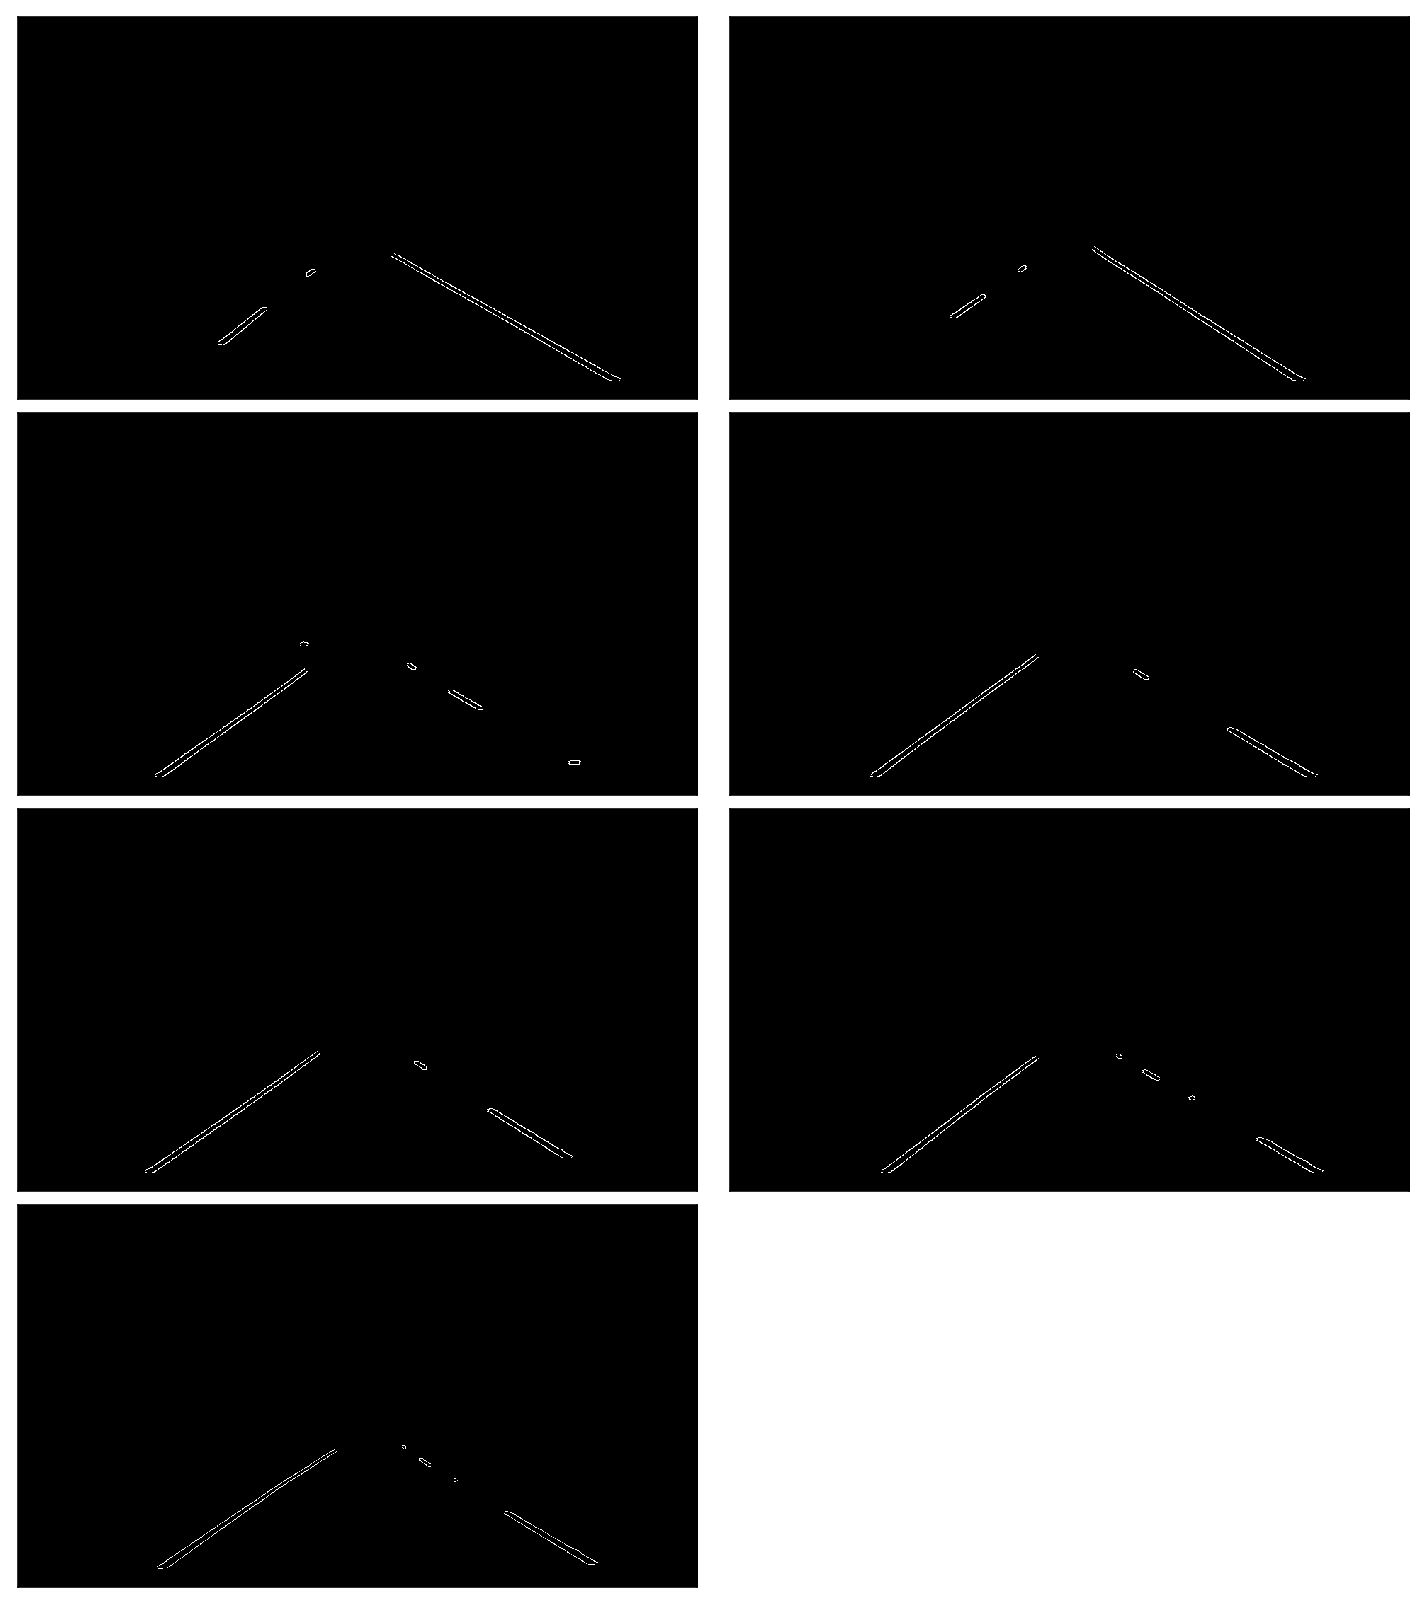

In [8]:
edge_images = list(map(lambda image: detect_edges(image), blurred_images))
show_images(edge_images)

In [9]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)


list_of_lines = list(map(hough_lines, roi_images))

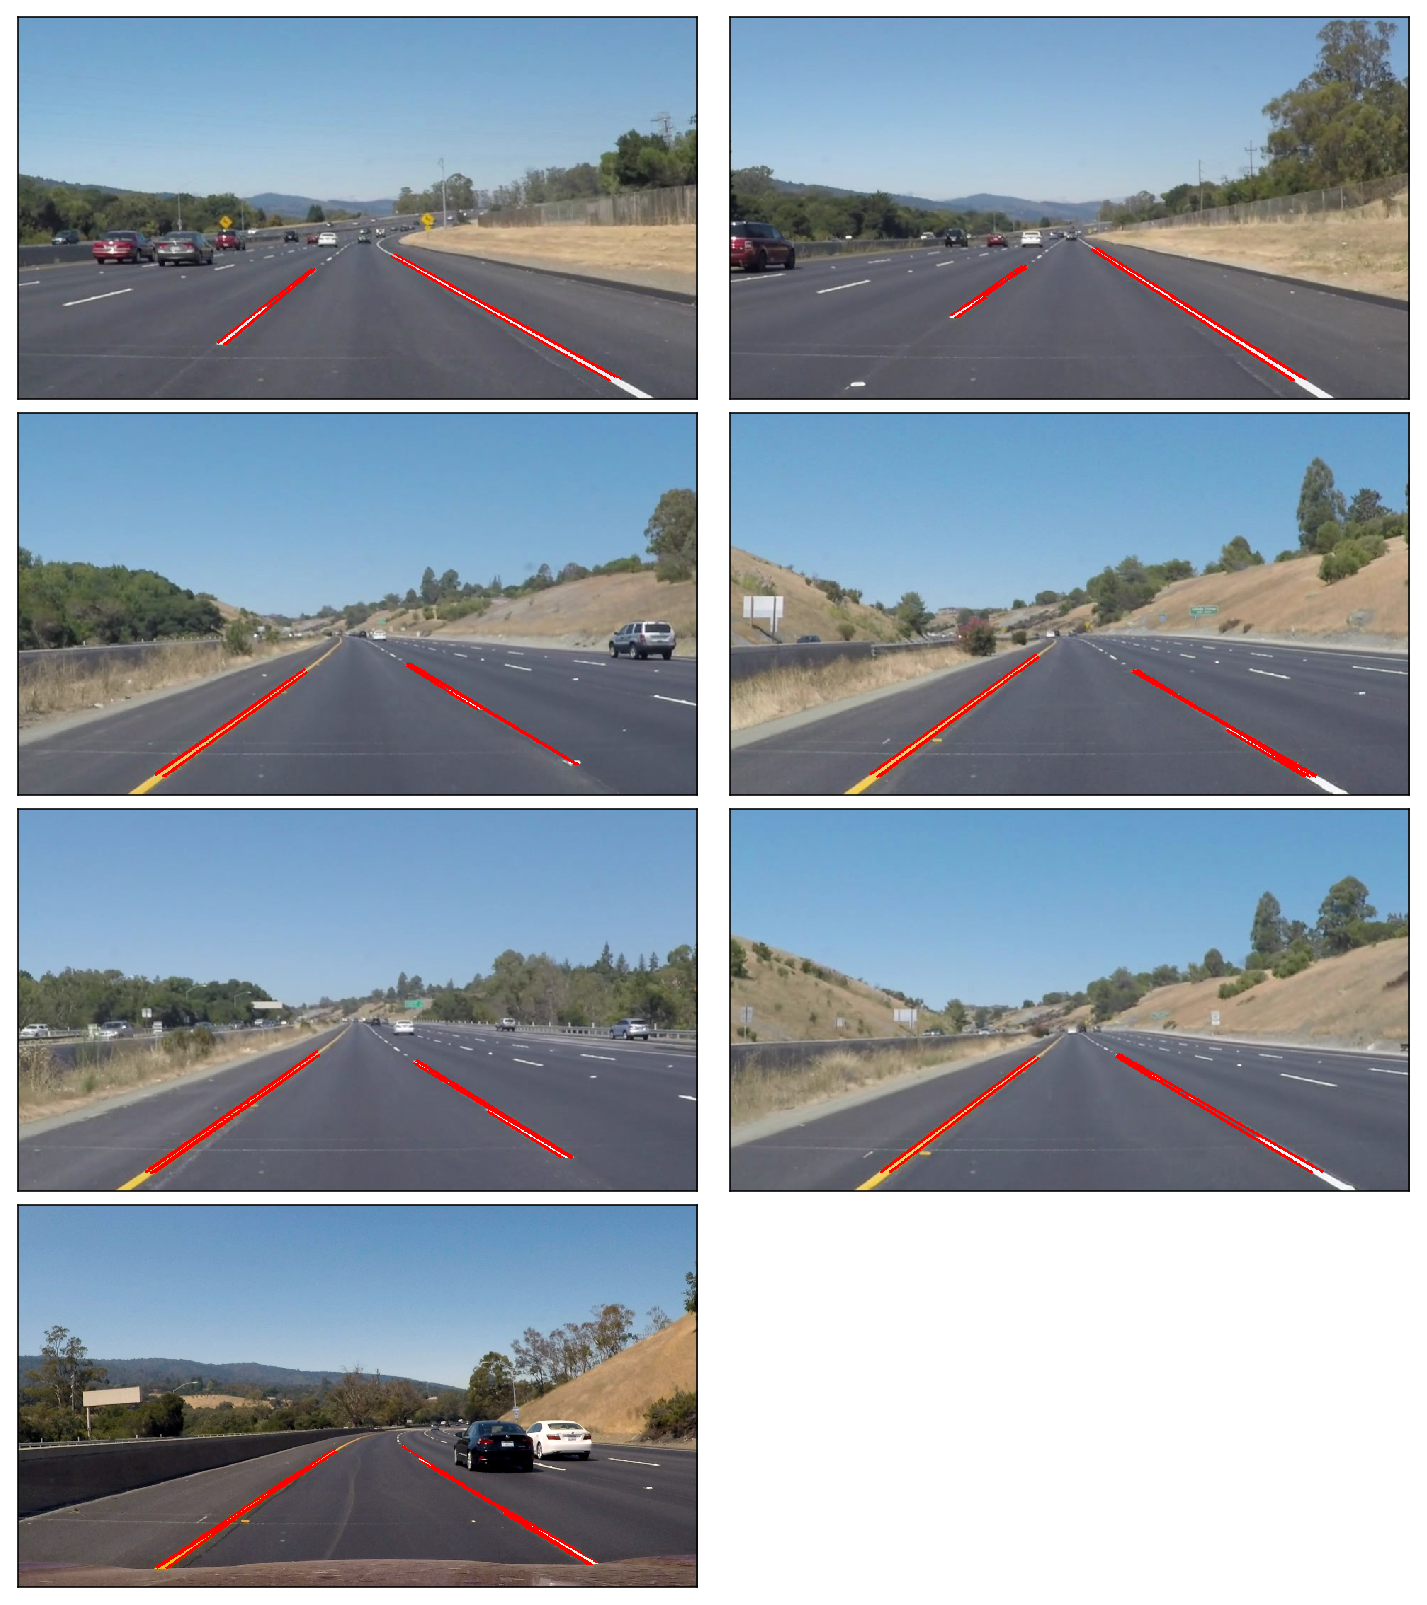

In [10]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

In [11]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

In [12]:
def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

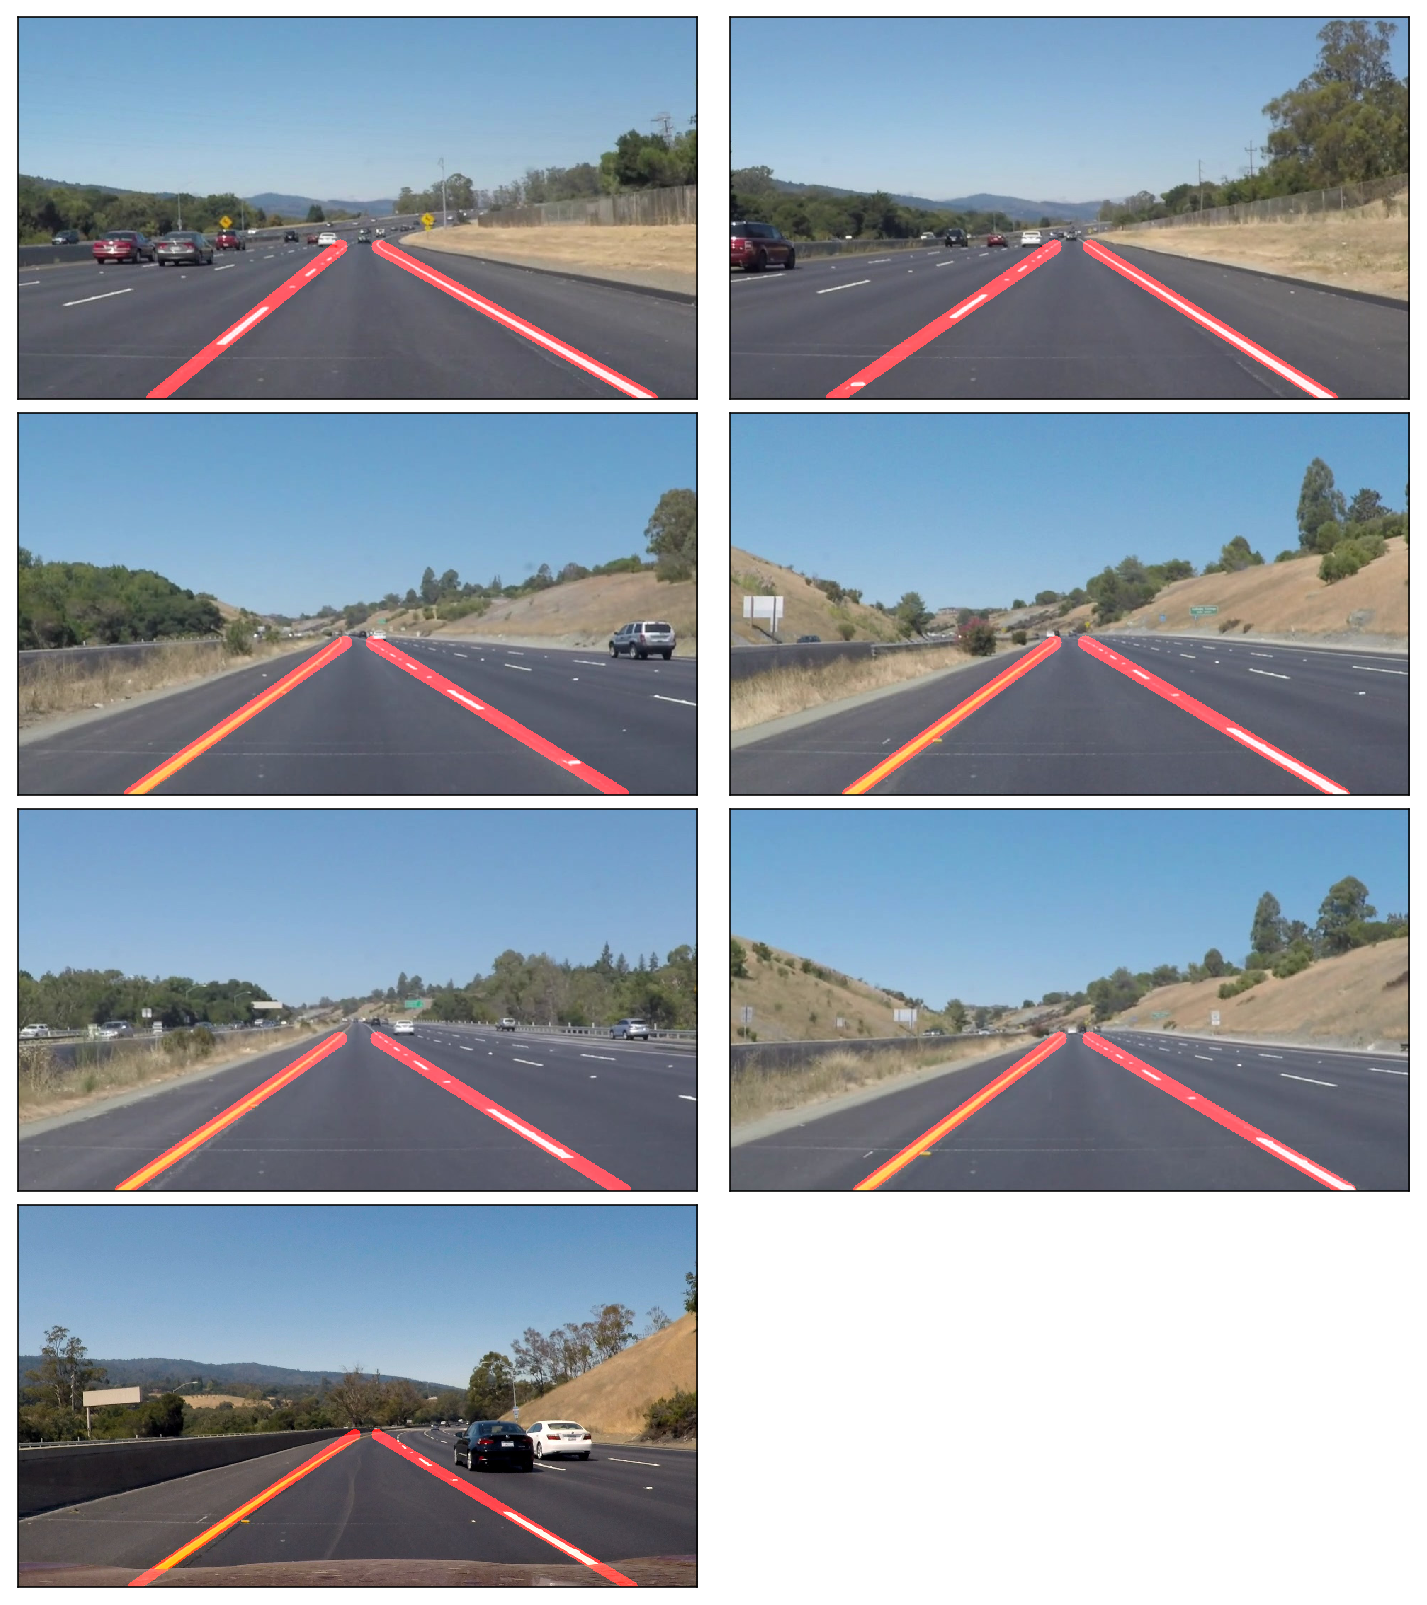

In [13]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)
             
    
lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
show_images(lane_images)

In [14]:
from collections import deque

QUEUE_LENGTH=50

class LaneDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)

    def process(self, image):
        white_yellow = select_rgb_color(image)
        gray         = convert_gray_scale(white_yellow)
        smooth_gray  = apply_smoothing(gray)
        edges        = detect_edges(smooth_gray)
        regions      = select_region(edges)
        lines        = hough_lines(regions)
        left_line, right_line = lane_lines(image, lines)

        def mean_line(line, lines):
            if line is not None:
                lines.append(line)

            if len(lines)>0:
                line = np.mean(lines, axis=0, dtype=np.int32)
                line = tuple(map(tuple, line)) # make sure it's tuples not numpy array for cv2.line to work
            return line

        left_line  = mean_line(left_line,  self.left_lines)
        right_line = mean_line(right_line, self.right_lines)

        return draw_lane_lines(image, (left_line, right_line))

In [15]:
def process_video(video_input, video_output):
    detector = LaneDetector()

    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('output_videos', video_output), audio=False)

In [17]:
%time process_video('solidWhiteRight.mp4', 'white.mp4')  

[MoviePy] >>>> Building video output_videos\white.mp4
[MoviePy] Writing video output_videos\white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:14<00:00, 15.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos\white.mp4 

Wall time: 16.1 s


In [18]:
%time process_video('solidYellowLeft.mp4', 'yellow.mp4')

[MoviePy] >>>> Building video output_videos\yellow.mp4
[MoviePy] Writing video output_videos\yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:33<00:00, 20.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos\yellow.mp4 

Wall time: 35.2 s


In [19]:
%time process_video('challenge.mp4', 'extra.mp4')

[MoviePy] >>>> Building video output_videos\extra.mp4
[MoviePy] Writing video output_videos\extra.mp4


100%|████████████████████████████████████████| 251/251 [00:25<00:00, 12.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos\extra.mp4 

Wall time: 28.9 s
